### Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2400 non-null   float64
 1   bath            2400 non-null   float64
 2   acre_lot        2400 non-null   float64
 3   zip_code        2400 non-null   float64
 4   house_size      2400 non-null   float64
 5   prev_sold_date  2400 non-null   object 
 6   price           2400 non-null   float64
dtypes: float64(6), object(1)
memory usage: 131.4+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2400 non-null   float64
 1   bath            2400 non-null   float64
 2   acre_lot        2400 non-null   float64
 3   zip_code        2400 non-null   float64
 4   house_size      2400 non-null   float64
 5   price           2400 non-null   float64
 6   prev_sold_year  2400 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 131.4 KB


#### Create a new feature in the housing data for Zip Code with a leading zero

In [5]:
outliers_df["zip_code_str"] = np.where(outliers_df.zip_code.apply(int) < 10000,'0'+ outliers_df.zip_code.apply(int).apply(str),outliers_df.zip_code.apply(int).apply(str))
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,zip_code_str
0,4.0,3.0,2.34,6238.0,3320.0,579900.0,2021,06238
1,1.0,1.0,0.17,6279.0,680.0,65000.0,2019,06279
2,2.0,1.0,0.36,6066.0,860.0,144900.0,2016,06066
3,2.0,2.0,0.17,6074.0,1168.0,172500.0,2020,06074
4,3.0,2.0,5.88,6071.0,1152.0,89900.0,2017,06071


#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [6]:
zip_lon_lat = pd.read_csv('ct_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,6001,41.787159,-72.852046,06001
1,6002,41.844930,-72.740951,06002
2,6010,41.681578,-72.940749,06010
3,6013,41.749079,-72.948657,06013
4,6016,41.901899,-72.547432,06016


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [7]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code_str")
merged_df.tail()

,bed,bath,acre_lot,zip_code_x,house_size,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
2395,2.0,2.0,0.17,6907.0,1031.0,349900.0,2020,06907,6907,41.100918,-73.520517
2396,3.0,3.0,0.17,6907.0,1738.0,469000.0,2017,06907,6907,41.100918,-73.520517
2397,1.0,1.0,0.17,6907.0,844.0,275000.0,2018,06907,6907,41.100918,-73.520517
2398,3.0,4.0,1.00,6896.0,2471.0,729000.0,2019,06896,6896,41.305415,-73.392584
2399,3.0,4.0,0.17,6896.0,2408.0,750000.0,2017,06896,6896,41.305415,-73.392584


#### Create common variables to store frequently used values.

In [8]:
features = ["latitude", "longitude", "bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [12]:
knn_gscv = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(40, 50, 1)})

In [13]:
knn_gscv.fit(X,y)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(40, 50)})

In [14]:
print(f"Best parameters found: {knn_gscv.best_params_}")

Best parameters found: {'n_neighbors': 44}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
knn_bp = KNeighborsRegressor(**knn_gscv.best_params_)
knn_bp_gscv = GridSearchCV(knn_bp,param_grid={})
knn_bp_model = knn_bp_gscv.fit(X_train,y_train)
knn_bp_predict = knn_bp_gscv.predict(X_test)

print_more_stuff("KNN Best Params",y_test,knn_bp_predict, knn_bp_gscv)

KNN Best Params EVS = 0.343461846
KNN Best Params MSE = 94,763,737,443.140488
KNN Best Params MAE = 180,492.520360
KNN Best Params R2 = 0.343451
KNN Best Params Fit Time = 0.0034323692321777343


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [16]:
knn_sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=num_features_to_select)
knn_sfs.fit(X, y)
knn_sfs_selected_features = knn_sfs.get_support()
print('The selected features are:', list(X.columns[knn_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


#### The default parameters for KNN Regressor are used instead of the best params.

In [17]:
X_sfs = merged_df[list(X.columns[knn_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [18]:
knn_sfs = KNeighborsRegressor()
knn_sfs_gscv = GridSearchCV(knn_sfs,param_grid={})
knn_sfs_model = knn_sfs_gscv.fit(X_sfs_train,y_sfs_train)
knn_sfs_predict = knn_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector", y_sfs_test, knn_sfs_predict, knn_sfs_gscv)

Sequential Feature Selector EVS = 0.562582899
Sequential Feature Selector MSE = 63,584,516,664.663940
Sequential Feature Selector MAE = 143,169.910278
Sequential Feature Selector R2 = 0.559469
Sequential Feature Selector Fit Time = 0.0017270565032958985


#### Graphing the results works best when the data is provided in a DataFrame.

In [19]:
knn_bp_predict_df = pd.DataFrame(knn_bp_predict).reset_index()
knn_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

knn_sfs_predict_df = pd.DataFrame(knn_sfs_predict).reset_index()
knn_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

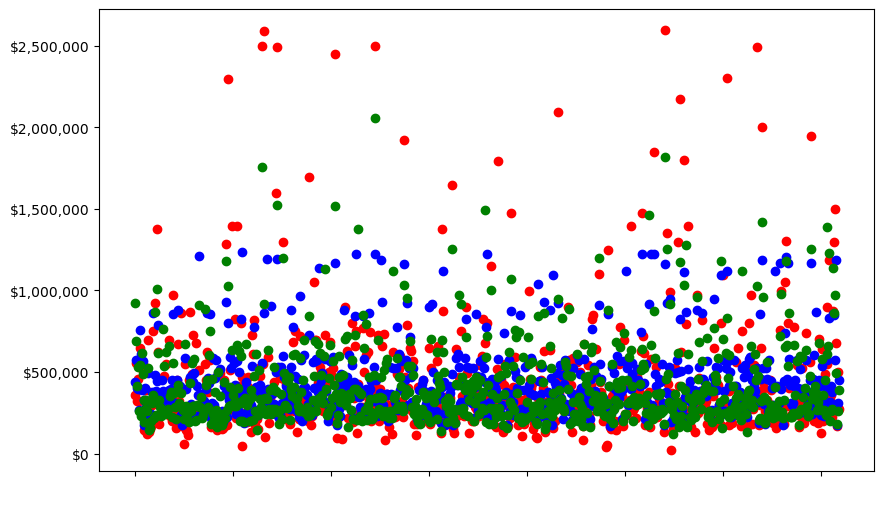

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="blue")
plt.scatter(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [21]:
knn_bp_predict_df.sort_values(by='prediction', inplace=True)
knn_bp_predict_df.reset_index(inplace=True)

knn_sfs_predict_df.sort_values(by='prediction', inplace=True)
knn_sfs_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Sequential Feature Selection, and Test Data.

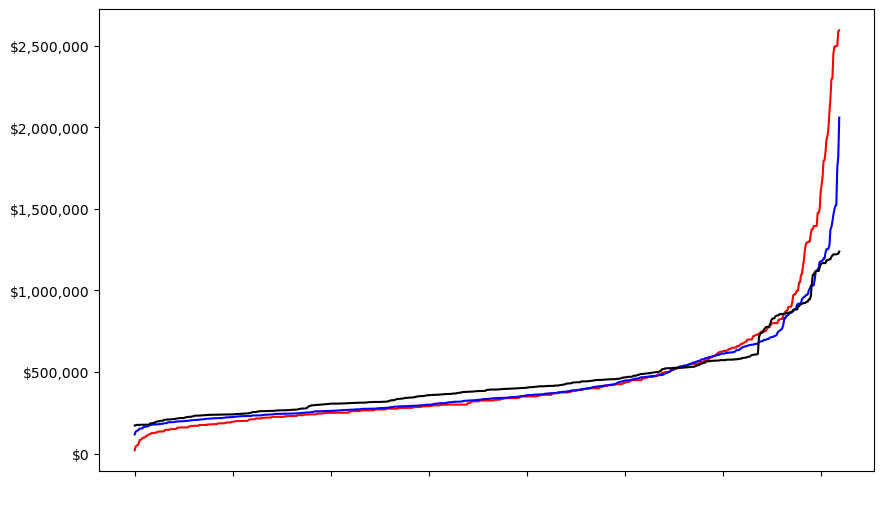

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="blue")
plt.plot(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [23]:
results_dict

{'model': ['KNN Best Params', 'Sequential Feature Selector'],
 'explained variance score': ['0.343461846', '0.562582899'],
 'mae score': ['180,492.520360', '143,169.910278'],
 'mse score': ['94,763,737,443.140488', '63,584,516,664.663940'],
 'r2 score': ['0.343451', '0.559469'],
 'mean fit time': [0.0034323692321777343, 0.0017270565032958985]}

In [24]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
KNN Best Params,0.343461846,"180,492.520360","94,763,737,443.140488",0.343451,0.003432
Sequential Feature Selector,0.562582899,"143,169.910278","63,584,516,664.663940",0.559469,0.001727
